In [335]:
%run "curve_fit_.ipynb"
%run "data_processing_.ipynb" #HEADER_LEN,X_DIM,Y_DIM,X_left_boundry,X_right_boundry,Y_left_boundry,Y_right_boundry
%run "evaluation_functions_.ipynb"
%run "fitting_functions_.ipynb"
%run "get_temperature_.ipynb"
%run "load_data_.ipynb" # frame rate, shutter delay, and interseted position 
%run "get_backbround_average_.ipynb" 
%run "frame_vs_temperature.ipynb" # get_powers

# Input Here

### 1. name of the folder containing different velocity's picture

In [336]:
folder = "/Users/chiaentsai/Box/MURI-SARA/Thermoreflectance/Joanne/12102022"


In [337]:
all_files, fivemm_files, velocity_path_list, velocity_list, used_frame_num = get_needed_files(folder)
back_intensity_list = get_background_average(fivemm_files)
power_list = get_powers(all_files)

### 2. Si&gold melting power

In [338]:
Si_melting_W = {
    '103': 48.8,
    #'13': 41.5,
    '155': 50.8,
    '190': 52.5, 
    #'20': 42.6,
    '234': 54.3,
    '30': 42.9,
    '352': 58.5,
    '45': 44.2,
    #'68': 46.9,
    '9': 40.9
}

In [339]:
gold_melting_W = {
    '103': 45.8,
    #'13': 37.2,
    '155': 47.7,
    '190': 49.7, 
    #'20': 38.4,
    '234': 50.4,
    '30': 39.1,
    '352': 54.4,
    '45': 40.7,
    #'68': 43,
    '9': 35.3
}

# get peak dR/R

In [340]:
v_list = ['103', '155','190', '234', '30', '352', '45', '9']
Dict_1 = dict((k, fivemm_files[k][10:]) for k in Si_list) # not included 0W files
back_intensity_list_1 = []
for key in fivemm_files:
    if key in v_list:
        index = list(fivemm_files).index(key)
        back_intensity_list_1.append(back_intensity_list[index])
dRoverR_1 = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_peak_dRoverR(file, back_intensity_list_1[i], two_lorentz, two_lorentz)
        con.append(val)
    dRoverR_1.append(con)

# power used (change start power if needed)

In [341]:
power_used = {'103':[31+2*p for p in range(0,len(dRoverR_1[v_list.index('103')]),1)], 
        #'13':[25+2*p for p in range(0,len(dRoverR_1[v_list.index('13')]),1)], 
        '155':[33+2*p for p in range(0,len(dRoverR_1[v_list.index('155')]),1)],
        '190':[35+2*p for p in range(0,len(dRoverR_1[v_list.index('190')]),1)], 
        #'20':[27+2*p for p in range(0,len(dRoverR_1[v_list.index('20')]),1)], 
        '234':[37+2*p for p in range(0,len(dRoverR_1[v_list.index('234')]),1)], 
        '30':[29+2*p for p in range(0,len(dRoverR_1[v_list.index('30')]),1)], 
        '352':[39+2*p for p in range(0,len(dRoverR_1[v_list.index('352')]),1)], 
        '45':[29+2*p for p in range(0,len(dRoverR_1[v_list.index('45')]),1)], 
        #'68':[29+2*p for p in range(0,len(dRoverR_1[v_list.index('68')]),1)], 
        '9':[21+2*p for p in range(0,len(dRoverR_1[v_list.index('9')]),1)]}

# plot dR/R

In [342]:
for i, v in enumerate(list(Si_melting_W.keys())):
    plt.plot(power_used[v], dRoverR_1[i], '.')
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si_dRoverR_figure_12102022/{}mm.png".format(v), format="PNG")
    plt.close()

# get kappa (use glod and Si melting power)

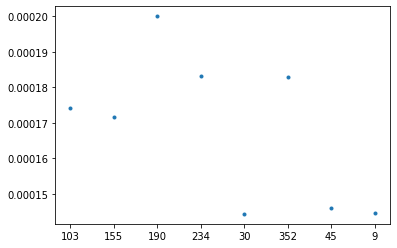

In [343]:
# gold and Si melt
import scipy.optimize
kappa_avg = []
for i, v in enumerate(list(Si_melting_W.keys())):
    popt, pcov = curve_fit(expo, power_used[v], dRoverR_1[i], p0 = [1, 0.000000047, 1], maxfev = 10000)
    #a, b, c = popt
    plt.plot(power_used[v], dRoverR_1[i], '.')
    y_pred = [expo(j, *popt) for j in power_used[v]]
    plt.plot(power_used[v], y_pred)
    plt.xlabel("power")
    plt.ylabel("dR/R")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/Si&gold_dRoverR_fit_figure_12102022/{}mm.png".format(v), format="PNG")
    plt.close()
    
    
    fun = lambda k: (expo(Si_melting_W[v], *popt) - (1410-21)*k)**2 + (expo(gold_melting_W[v], *popt) - (1064-21)*k)**2
    res = scipy.optimize.minimize(fun, 0.00016)
    temp_pred = [expo(j, *popt)/res.x for j in power_used[v]]
    plt.plot(power_used[v], temp_pred)
    
    plt.plot(Si_melting_W[v], 1410, marker="o",color = 'r', label='Si')
    plt.plot(gold_melting_W[v], 1064, marker="o", color = 'g', label='gold')
    plt.legend(loc="upper left")
    plt.xlabel("power")
    plt.ylabel("temperature")
    plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/gold_Si_fit_12102022/{}mm.png".format(v), format="PNG")
    plt.close()
    
#     f = expo(Si_melting_W[v], *popt)
#     gold_m = 1410
#     dT = gold_m - 21
#     kappa = f / dT
    kappa_avg.append(float(res.x))
    
Dict_kappa_avg = dict(zip(list(Si_melting_W.keys()),kappa_avg))

plt.plot(list(Si_melting_W.keys()), kappa_avg, '.')
plt.savefig("/Users/chiaentsai/Desktop/lab/Temperature_Calibration/kappa_gold&Si_12102022.png", format="PNG")

In [344]:
con = 0
for i, v in enumerate(Dict_kappa_avg.keys()):
    con = con + Dict_kappa_avg[v]
kappa_avg = con / len(Dict_kappa_avg)
kappa_avg

0.00016839278374213674

# get peak temperature (with average kappa)

In [345]:
peak_temp = []
for i, v in enumerate(list(Si_melting_W.keys())):
    tem = []
    for r in dRoverR_1[i]:
        t = get_peak_Temp(r, Dict_kappa_avg[v])
#         t = get_peak_Temp(r,avg_kappa)
#         t = get_peak_Temp(r,0.00016498400434141028)
#         t = get_peak_Temp(r, Dict_kappa_gold_avg[v])
#         t = get_peak_Temp(r, avg_kappa_2)
#         t = get_peak_Temp(r, Dict_kappa_avg[v])
        tem.append(t)
    peak_temp.append(tem)
    
Dict_peak_temp = dict(zip(list(Si_melting_W.keys()),peak_temp))

# fit plane f(power, log10 velocity) = Tpeak

In [359]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

def function(data, a, b, c, d, e, f, g, h):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Si_melting_W.keys())):
    P = [int(p) for p in power_used[v]]
    V = [np.log(int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[P,V,T])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # velocity
        z_data.append(item[2]) # temperature
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = z_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=1000000)
print(parameters)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

# for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
#     v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
#     p_data = [int(p) for p in power_used[i]]
#     t_data = Dict_peak_temp[v]
#     axes.scatter(p_data, v_data, t_data, s = 250)
axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('power - W', fontsize=30, labelpad=40)
axes.set_ylabel('ln(velocity) - mm/s',fontsize=30, labelpad=40)
axes.set_zlabel('peak temperature - C', fontsize=30, labelpad=40)
axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX
[ 1.07904788e+03 -1.97372757e+02 -1.73890868e+03  1.82157454e+02
  4.96514070e+03  1.11250495e+00  2.24302233e-02  8.85127330e+00]
1070.5487095622639


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_25539/507234216.py:25: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


### converter

In [363]:
parameters_T = np.array([ 1.07905058e+03, -1.97373310e+02, -1.73891144e+03,  1.82157825e+02,
        4.96514235e+03,  1.11250471e+00,  2.24302306e-02,  8.85130018e+00])

def get_power(dwell, Tpeak):
    v = 88200/dwell
    lnv = np.log(v)
    a, b, c, d, e, f, g, h= parameters_T
    eq1 = lambda x: (a+b*lnv+h*lnv**2)*x**(f+g*lnv) + (c+d*lnv)*x + e  - Tpeak
    sol = leastsq(eq1, 100)
    #return float(sol[0], sol[1]), float(sol[1])
    return float(sol[0])

In [365]:
get_power(88200/352, 660)

47.7310977740439

# plot temperature vs power

In [348]:
import matplotlib.pyplot as plt
%matplotlib

for velocity in np.unique(y_data):
    mask = y_data == velocity
    plt.plot(x_data[mask], z_data[mask])

plt.gca().legend(('103', '155','190', '234', '30', '352', '45', '9'))

Using matplotlib backend: MacOSX


# fit plane f(Tpeak, log10 tau) = power                 (beamwidth needed)

In [366]:
beamwidth = 88200

import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

# def function(data, a, b, c, d, e, f, g, h):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

def function(data, a, b, c, d, e, f, g):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a*x**b)*(c*y**d)+e*x+f*y+g

f = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes = Axes3D(f)

points = []
for i, v in enumerate(list(Si_melting_W.keys())):
    P = [int(p) for p in power_used[v]]
    tau = [np.log(beamwidth / int(v))] * len(Dict_peak_temp[v])
    T = Dict_peak_temp[v]
    point = [list(x) for x in zip(*[tau,T,P])]
    points.append(point)

x_data = []
y_data = []
z_data = []
for velo in points:
    for item in velo:
        x_data.append(item[0]) # tau/dwell time
        y_data.append(item[1]) # T
        z_data.append(item[2]) # power
        
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)

mask = y_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data = z_data[mask]

parameters, covariance = curve_fit(function, [x_data, y_data], z_data,  maxfev=100000)
print(parameters)
model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z = function(np.array([X, Y]), *parameters)

z_predicted = function([x_data, y_data], *parameters)
differences = np.subtract(z_data, z_predicted)
squared_differences = np.square(differences)
mse = squared_differences.mean()


axes.plot_surface(X, Y, Z, cmap=cm.hot, alpha=0.2)

# for i, v in enumerate(list(Dict_kappa_Si_avg.keys())):
#     v_data = [np.log(int(v))] * len(Dict_peak_temp[v])
#     p_data = [int(p) for p in power_used[i]]
#     t_data = Dict_peak_temp[v]
#     axes.scatter(p_data, v_data, t_data, s = 250)
axes.scatter(x_data, y_data, z_data, s=500)
    

axes.set_title('Scatter Plot')
axes.set_xlabel('tau/dwell time', fontsize=30, labelpad=40)
axes.set_ylabel('Tpeak - Celsius',fontsize=30, labelpad=40)
axes.set_zlabel('Power - W', fontsize=30, labelpad=40)
axes.set_ylim(400, 1400)
#axes.set_zlim(400, 1400)

axes.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse)

Using matplotlib backend: MacOSX


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_25539/168898424.py:32: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes = Axes3D(f)


[ 2.78578022e+00  4.05135921e-04 -2.72091616e+00  1.00170654e+00
 -4.35336455e+00  7.70163967e+00  4.91353859e+01]
1.6912031208795804


### converter

In [367]:
import numpy as np
from scipy.optimize import leastsq

parameters_to_power = np.array([ 2.78578022e+00 , 4.05135921e-04 ,-2.72091616e+00 , 1.00170654e+00,
 -4.35336455e+00 , 7.70163967e+00 , 4.91353859e+01])

def get_power_2(dwell, Tpeak):
    lntau = np.log(dwell)
    the_input = [lntau,Tpeak]
    a, b, c, d, e, f, g= parameters_to_power
    
    return function(the_input, a, b, c, d, e, f, g)

In [368]:
get_power_2(88200/352, 660)

46.215339271727245

# lateral temperature profile

In [308]:
dRoverR_allpoints = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    for file in Dict_1[v]:
        val = get_dR_over_R(file, back_intensity_list_1[i])
        con.append(val)
    dRoverR_allpoints.append(con)
    
dRoverR_lines = []
for velo in dRoverR_allpoints:
    con_1 = []
    for R in velo:
        val = R[round((X_right_boundry-X_left_boundry)/2),:]
        con_1.append(val)
    dRoverR_lines.append(con_1)

temp_lines = []    
for i, v in enumerate(list(Dict_1.keys())):
    con_2 = []
    velo = dRoverR_lines[i]
    for R in velo:
        temp = get_peak_Temp(R, Dict_kappa_avg[v])
        con_2.append(temp)
    temp_lines.append(con_2)
    
parameters = []
for i, v in enumerate(list(Dict_1.keys())):
    con = []
    velo = temp_lines[i]
    for t in velo:
        [height, x_0, sigma1, sigma2] = fit(two_lorentz, t)
        con.append([height, x_0, sigma1, sigma2])
    parameters.append(con)

## fit sigma1, sigma2 plane

In [328]:
import numpy, scipy, scipy.optimize
import matplotlib
from mpl_toolkits.mplot3d import  Axes3D
from matplotlib import cm # to colormap 3D surfaces from blue to red
import matplotlib.pyplot as plt
%matplotlib

# def function(data, b, c, d, e, f):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (b*y+c)*(x)**(d*y**2+e*y+f)

# def function(data, a, b, c, d, e, f, g, h):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e

# def function(data, a, b, c, d, e, f, g, h, i, j):
#     x = np.array(data[0])
#     y = np.array(data[1])
#     return (a+b*y+h*y**2)*x**(f+g*y) + (c+d*y)*x + e +i*x**2 + j*y**2

def function(data, a, b, c, d, e, f, g):
    x = np.array(data[0])
    y = np.array(data[1])
    return (a*x**b)*(c*y**d)+e*x+f*y+g


points_1 = []
points_2 = []
for i, v in enumerate(list(Si_melting_W.keys())):
    T = Dict_peak_temp[v]
    P = [int(p) for p in power_used[v]]
    tau = [np.log(beamwidth / int(v))] * len(Dict_peak_temp[v])
    sigma1 = [el[2] for el in parameters[i]]
    sigma2 = [el[3] for el in parameters[i]]
    point1 = [list(x) for x in zip(*[P,tau,sigma1,T])]
    points_1.append(point1)
    point2 = [list(x) for x in zip(*[P,tau,sigma2,T])]
    points_2.append(point2)

x_data = []
y_data = []
t_data = []
z_data_1 = []
z_data_2 = []

for velo in points_1:
    for item in velo:
        x_data.append(item[0]) # power
        y_data.append(item[1]) # tau
        z_data_1.append(item[2]) # sigma1
        t_data.append(item[3]) # Tpeak
        

for velo in points_2:
    for item in velo:
        z_data_2.append(item[2]) # sigma2
        
        
x_data, y_data, z_data_1, z_data_2, t_data = np.array(x_data), np.array(y_data), np.array(z_data_1), np.array(z_data_2), np.array(t_data)


mask = t_data > 400
x_data = x_data[mask]
y_data = y_data[mask]
z_data_1 = z_data_1[mask]
z_data_2 = z_data_2[mask]

parameters_1, covariance_1 = curve_fit(function, [x_data, y_data], z_data_1,  maxfev=1000000)
parameters_2, covariance_2 = curve_fit(function, [x_data, y_data], z_data_2,  maxfev=1000000)

print(parameters_1)
print(parameters_2)

model_x_data = np.linspace(min(x_data), max(x_data), 30)
model_y_data = np.linspace(min(y_data), max(y_data), 30)
X, Y = np.meshgrid(model_x_data, model_y_data)
Z1 = function(np.array([X, Y]), *parameters_1)
Z2 = function(np.array([X, Y]), *parameters_2)

z_predicted_1 = function([x_data, y_data], *parameters_1)
z_predicted_2 = function([x_data, y_data], *parameters_2)

differences_1 = np.subtract(z_data_1, z_predicted_1)
differences_2 = np.subtract(z_data_2, z_predicted_2)

squared_differences_1 = np.square(differences_1)
squared_differences_2 = np.square(differences_2)

mse_1 = squared_differences_1.mean()
mse_2 = squared_differences_2.mean()

Using matplotlib backend: MacOSX
[-6.43292514e-05  8.12473807e-01 -2.30164280e-05  6.60938337e-01
  9.37940498e-02  1.46558068e+01 -6.75393606e+01]
[ 1.16083703e+02  1.00260464e+00  1.16383411e+02  1.66658832e-03
 -1.37270237e+04 -1.74887745e+02  2.98986471e+03]


In [333]:
f1 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes1 = Axes3D(f1)

axes1.plot_surface(X, Y, Z1, cmap=cm.hot, alpha=0.2)
axes1.scatter(x_data, y_data, z_data_1, s=500)

axes1.set_title('Scatter Plot')
axes1.set_xlabel('power - W', fontsize=30, labelpad=40)
axes1.set_ylabel('tau',fontsize=30, labelpad=40)
axes1.set_zlabel('sigma1', fontsize=30, labelpad=40)

axes1.tick_params(axis='both', which='major', labelsize=30)
 
plt.show()
print(mse_1)

23851.122474752225


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_25539/3209302835.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes1 = Axes3D(f1)


In [334]:
f2 = plt.figure(figsize=(20.0, 20.0), dpi=20)
matplotlib.pyplot.grid(True)
axes2 = Axes3D(f2)

axes2.plot_surface(X, Y, Z2, cmap=cm.hot, alpha=0.2)
axes2.scatter(x_data, y_data, z_data_2, s=500)

axes2.set_title('Scatter Plot')
axes2.set_xlabel('power - W', fontsize=30, labelpad=40)
axes2.set_ylabel('tau',fontsize=30, labelpad=40)
axes2.set_zlabel('sigma2', fontsize=30, labelpad=40)

axes2.tick_params(axis='both', which='major', labelsize=30)

plt.show()
print(mse_2)

17481.00310444905


/var/folders/f7/kn96xdj93ss0t67sn2q10n6c0000gn/T/ipykernel_25539/3592995763.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  axes2 = Axes3D(f2)
